In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [2]:
df_train = pd.read_csv('data/Train/Train.csv', header=0)
df_camps = pd.read_csv('data/Train/Health_Camp_Detail.csv', header=0)
df_patients = pd.read_csv('data/Train/Patient_Profile.csv', header=0)

df_first_camp = pd.read_csv('data/Train/First_Health_Camp_Attended.csv', header=0)
df_second_camp = pd.read_csv('data/Train/Second_Health_Camp_Attended.csv', header=0)
df_third_camp = pd.read_csv('data/Train/Third_Health_Camp_Attended.csv', header=0)

df_test = pd.read_csv('data/test.csv', header=0)
submission = pd.read_csv('data/sample_submission.csv', header=0)

In [3]:
df_train.shape, df_camps.shape, df_patients.shape, df_first_camp.shape, df_second_camp.shape, df_third_camp.shape, df_test.shape, submission.shape

((75278, 8),
 (65, 6),
 (37633, 11),
 (6218, 5),
 (7819, 3),
 (6515, 4),
 (35249, 8),
 (35249, 3))

In [4]:
df_train.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,489652,6578,10-Sep-05,4,0,0,0,2
1,507246,6578,18-Aug-05,45,5,0,0,7
2,523729,6534,29-Apr-06,0,0,0,0,0
3,524931,6535,07-Feb-04,0,0,0,0,0
4,521364,6529,28-Feb-06,15,1,0,0,7


In [5]:
df_test.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,505701,6548,21-May-06,1,0,0,0,2
1,500633,6584,02-Jun-06,0,0,0,0,0
2,506945,6582,10-Aug-06,0,0,0,0,0
3,497447,6551,27-Aug-06,0,0,0,0,0
4,496446,6533,19-Sep-06,0,0,0,0,0


In [6]:
df_camps.head()

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,16-Aug-03,20-Aug-03,First,B,2
1,6530,16-Aug-03,28-Oct-03,First,C,2
2,6544,03-Nov-03,15-Nov-03,First,F,1
3,6585,22-Nov-03,05-Dec-03,First,E,2
4,6561,30-Nov-03,18-Dec-03,First,E,1


In [7]:
df_patients.head()

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,516956,0,0,0,0,1,90,39,18-Jun-03,NaN,Software Industry
1,507733,0,0,0,0,1,None,40,20-Jul-03,H,Software Industry
2,508307,0,0,0,0,3,87,46,02-Nov-02,D,BFSI
3,512612,0,0,0,0,1,75,47,02-Nov-02,D,Education
4,521075,0,0,0,0,3,None,80,24-Nov-02,H,Others


In [8]:
submission.head()

,Patient_ID,Health_Camp_ID,Outcome
0,505701,6548,0.5
1,500633,6584,0.5
2,506945,6582,0.5
3,497447,6551,0.5
4,496446,6533,0.5


In [9]:
df_first_camp.head()

,Patient_ID,Health_Camp_ID,Donation,Health_Score,Unnamed: 4
0,506181,6560,40,0.439024,NaN
1,494977,6560,20,0.097561,NaN
2,518680,6560,10,0.048780,NaN
3,509916,6560,30,0.634146,NaN
4,488006,6560,20,0.024390,NaN


In [10]:
df_second_camp.head()

,Patient_ID,Health_Camp_ID,Health Score
0,526631,6536,0.875136
1,509122,6536,0.755700
2,498864,6536,0.673181
3,515398,6536,0.722041
4,504624,6536,0.464712


In [11]:
df_third_camp.head()

,Patient_ID,Health_Camp_ID,Number_of_stall_visited,Last_Stall_Visited_Number
0,517875,6527,3,1
1,504692,6578,1,1
2,504692,6527,3,1
3,493167,6527,4,4
4,510954,6528,2,2


In [12]:
pd.merge(df_first_camp[['Patient_ID']], df_second_camp[['Patient_ID']], on='Patient_ID').shape

(5212, 1)

In [13]:
df_first_camp.shape, df_second_camp.shape, df_third_camp.shape

((6218, 5), (7819, 3), (6515, 4))

In [14]:
min(df_first_camp.Health_Score), max(df_first_camp.Health_Score), min(df_second_camp['Health Score']), max(df_second_camp['Health Score']), min(df_third_camp.Number_of_stall_visited), max(df_third_camp.Number_of_stall_visited)

(0.0016666670000000001, 1.0, 0.058992805999999995, 1.0, 0, 7)

In [15]:
df_first_camp['label'] = df_first_camp['Health_Score'].apply(lambda x: 1 if x > 0 else 0)
df_second_camp['label'] = df_second_camp['Health Score'].apply(lambda x: 1 if x > 0 else 0)
df_third_camp['label'] = df_third_camp['Number_of_stall_visited'].apply(lambda x: 1 if x > 0 else 0)

df_label = pd.concat((df_first_camp[['Patient_ID', 'Health_Camp_ID', 'label']], df_second_camp[['Patient_ID', 'Health_Camp_ID', 'label']], df_third_camp[['Patient_ID', 'Health_Camp_ID', 'label']]))

print(df_first_camp.shape, df_second_camp.shape, df_third_camp.shape, df_label.shape)
assert df_first_camp.shape[0] + df_second_camp.shape[0] + df_third_camp.shape[0] == df_label.shape[0]

(6218, 6) (7819, 4) (6515, 5) (20552, 3)


In [16]:
df_train = pd.merge(df_train, df_camps, on=['Health_Camp_ID'], how='left')
df_train = pd.merge(df_train, df_patients, on=['Patient_ID'], how='left')

# df_train = pd.merge(df_train, df_first_camp, on=['Patient_ID', 'Health_Camp_ID'], how='left')
# df_train = pd.merge(df_train, df_second_camp, on=['Patient_ID', 'Health_Camp_ID'], how='left')
# df_train = pd.merge(df_train, df_third_camp, on=['Patient_ID', 'Health_Camp_ID'], how='left')
df_train = pd.merge(df_train, df_label, on=['Patient_ID', 'Health_Camp_ID'], how='left')
df_train['label'] = df_train['label'].fillna(0)

In [17]:
df_test = pd.merge(df_test, df_camps, on=['Health_Camp_ID'], how='left')
df_test = pd.merge(df_test, df_patients, on=['Patient_ID'], how='left')

In [18]:
df_train.shape, df_test.shape

((75278, 24), (35249, 23))

In [19]:
df_train.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Camp_Start_Date,Camp_End_Date,...,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,label
0,489652,6578,10-Sep-05,4,0,0,0,2,16-Aug-05,14-Oct-05,...,0,0,0,None,None,None,06-Dec-04,NaN,NaN,1.0
1,507246,6578,18-Aug-05,45,5,0,0,7,16-Aug-05,14-Oct-05,...,0,0,0,1,75,40,08-Sep-04,C,Others,0.0
2,523729,6534,29-Apr-06,0,0,0,0,0,17-Oct-05,07-Nov-07,...,0,0,0,None,None,None,22-Jun-04,NaN,NaN,1.0
3,524931,6535,07-Feb-04,0,0,0,0,0,01-Feb-04,18-Feb-04,...,0,0,0,None,None,None,07-Feb-04,I,NaN,0.0
4,521364,6529,28-Feb-06,15,1,0,0,7,30-Mar-06,03-Apr-06,...,0,0,1,1,70,40,04-Jul-03,I,Technology,1.0


In [20]:
df_test.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Camp_Start_Date,Camp_End_Date,...,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,505701,6548,21-May-06,1,0,0,0,2,13-Jun-06,18-Aug-06,...,0,0,0,0,0,None,44,05-Feb-03,E,NaN
1,500633,6584,02-Jun-06,0,0,0,0,0,04-Aug-06,09-Aug-06,...,0,1,0,0,1,67,41,11-Dec-04,D,Consulting
2,506945,6582,10-Aug-06,0,0,0,0,0,06-Apr-06,07-Nov-07,...,0,0,0,0,None,None,None,19-Apr-06,NaN,NaN
3,497447,6551,27-Aug-06,0,0,0,0,0,13-Nov-06,18-Nov-06,...,0,0,0,0,0,None,47,25-Aug-06,B,NaN
4,496446,6533,19-Sep-06,0,0,0,0,0,20-Sep-06,23-Sep-06,...,0,0,0,0,None,None,None,19-Sep-06,B,NaN


In [21]:
df_train['label'].value_counts()

0.0    54744
1.0    20534
Name: label, dtype: int64

In [22]:
df_train.dtypes, df_test.dtypes

(Patient_ID             int64
 Health_Camp_ID         int64
 Registration_Date     object
 Var1                   int64
 Var2                   int64
 Var3                   int64
 Var4                   int64
 Var5                   int64
 Camp_Start_Date       object
 Camp_End_Date         object
 Category1             object
 Category2             object
 Category3              int64
 Online_Follower        int64
 LinkedIn_Shared        int64
 Twitter_Shared         int64
 Facebook_Shared        int64
 Income                object
 Education_Score       object
 Age                   object
 First_Interaction     object
 City_Type             object
 Employer_Category     object
 label                float64
 dtype: object,
 Patient_ID            int64
 Health_Camp_ID        int64
 Registration_Date    object
 Var1                  int64
 Var2                  int64
 Var3                  int64
 Var4                  int64
 Var5                  int64
 Camp_Start_Date      object
 Ca

In [23]:
df_train.apply(lambda x: sum(pd.isna(x)), axis=0)

Patient_ID               0
Health_Camp_ID           0
Registration_Date      334
Var1                     0
Var2                     0
Var3                     0
Var4                     0
Var5                     0
Camp_Start_Date          0
Camp_End_Date            0
Category1                0
Category2                0
Category3                0
Online_Follower          0
LinkedIn_Shared          0
Twitter_Shared           0
Facebook_Shared          0
Income                   0
Education_Score          0
Age                      0
First_Interaction        0
City_Type            33208
Employer_Category    60075
label                    0
dtype: int64

In [24]:
df_train.Income.value_counts(), df_train.Education_Score.value_counts(), df_train.Age.value_counts(), df_train.First_Interaction.value_counts(), df_train.City_Type.value_counts(), df_train.Employer_Category.value_counts()

(None    53546
 0        8393
 1        5346
 2        4108
 3        2155
 4        1034
 5         440
 6         256
 Name: Income, dtype: int64,
 None           65345
 82               468
 79               423
 75               413
 86               390
                ...  
 78.43333333        1
 72.875             1
 67.325             1
 78.05              1
 80.43333333        1
 Name: Education_Score, Length: 228, dtype: int64,
 None    51612
 41       1843
 40       1760
 42       1676
 43       1628
 39       1477
 44       1460
 45       1094
 37       1033
 46       1025
 38        996
 47        885
 72        792
 48        736
 73        710
 49        644
 71        593
 74        540
 36        477
 50        446
 52        418
 51        416
 70        394
 35        360
 53        315
 54        222
 34        191
 56        189
 75        167
 55        147
 76        131
 69        118
 58        111
 59         88
 67         87
 33         68
 57         68
 77

In [25]:
# np.median(df_train.loc[pd.notna(df_train['Income']), 'Income'])

In [26]:
df_train['Income'] = df_train['Income'].apply(lambda x: np.nan if x == 'None' else x).astype('float')
df_test['Income'] = df_test['Income'].apply(lambda x: np.nan if x == 'None' else x).astype('float')

df_train['Education_Score'] = df_train['Education_Score'].apply(lambda x: np.nan if x == 'None' else x).astype('float')
df_test['Education_Score'] = df_test['Education_Score'].apply(lambda x: np.nan if x == 'None' else x).astype('float')

df_train['Age'] = df_train['Age'].apply(lambda x: np.nan if x == 'None' else x).astype('float')
df_test['Age'] = df_test['Age'].apply(lambda x: np.nan if x == 'None' else x).astype('float')

In [27]:
le_Category1, le_Category2, le_City_Type, le_Employer_Category = preprocessing.LabelEncoder(), preprocessing.LabelEncoder(), preprocessing.LabelEncoder(), preprocessing.LabelEncoder()

In [28]:
le_Category1.fit(df_train.loc[pd.notna(df_train['Category1']), 'Category1'])
le_Category2.fit(df_train.loc[pd.notna(df_train['Category2']), 'Category2'])
le_City_Type.fit(df_train.loc[pd.notna(df_train['City_Type']), 'City_Type'])
le_Employer_Category.fit(df_train.loc[pd.notna(df_train['Employer_Category']), 'Employer_Category'])

LabelEncoder()

In [29]:
missing_impute = -999

In [30]:
df_train['Category1'] = df_train['Category1'].apply(lambda x: missing_impute if pd.isna(x) else le_Category1.transform([x])[0])
df_train['Category2'] = df_train['Category2'].apply(lambda x: missing_impute if pd.isna(x) else le_Category2.transform([x])[0])
df_train['City_Type'] = df_train['City_Type'].apply(lambda x: missing_impute if pd.isna(x) else le_City_Type.transform([x])[0])
df_train['Employer_Category'] = df_train['Employer_Category'].apply(lambda x: missing_impute if pd.isna(x) else le_Employer_Category.transform([x])[0])

In [31]:
df_test['Category1'] = df_test['Category1'].apply(lambda x: missing_impute if pd.isna(x) else le_Category1.transform([x])[0])
df_test['Category2'] = df_test['Category2'].apply(lambda x: missing_impute if pd.isna(x) else le_Category2.transform([x])[0])
df_test['City_Type'] = df_test['City_Type'].apply(lambda x: missing_impute if pd.isna(x) else le_City_Type.transform([x])[0])
df_test['Employer_Category'] = df_test['Employer_Category'].apply(lambda x: missing_impute if pd.isna(x) else le_Employer_Category.transform([x])[0])

In [32]:
#dates
# Registration_Date, Camp_Start_Date, Camp_End_Date, First_Interaction

df_train['Registration_Date'] = pd.to_datetime(df_train['Registration_Date'], format='%d-%b-%y')
df_train['Camp_Start_Date'] = pd.to_datetime(df_train['Camp_Start_Date'], format='%d-%b-%y')
df_train['Camp_End_Date'] = pd.to_datetime(df_train['Camp_End_Date'], format='%d-%b-%y')
df_train['First_Interaction'] = pd.to_datetime(df_train['First_Interaction'], format='%d-%b-%y')

df_test['Registration_Date'] = pd.to_datetime(df_test['Registration_Date'], format='%d-%b-%y')
df_test['Camp_Start_Date'] = pd.to_datetime(df_test['Camp_Start_Date'], format='%d-%b-%y')
df_test['Camp_End_Date'] = pd.to_datetime(df_test['Camp_End_Date'], format='%d-%b-%y')
df_test['First_Interaction'] = pd.to_datetime(df_test['First_Interaction'], format='%d-%b-%y')

In [33]:
df_train['Registration_weekday'] = df_train['Registration_Date'].apply(lambda x: x.weekday())
df_train['Registration_weekofyear'] = df_train['Registration_Date'].apply(lambda x: x.weekofyear)
df_train['Registration_month'] = df_train['Registration_Date'].apply(lambda x: x.month)
df_train['Registration_quarter'] = df_train['Registration_Date'].apply(lambda x: x.quarter)
df_train['Registration_year'] = df_train['Registration_Date'].apply(lambda x: x.year)

df_test['Registration_weekday'] = df_test['Registration_Date'].apply(lambda x: x.weekday())
df_test['Registration_weekofyear'] = df_test['Registration_Date'].apply(lambda x: x.weekofyear)
df_test['Registration_month'] = df_test['Registration_Date'].apply(lambda x: x.month)
df_test['Registration_quarter'] = df_test['Registration_Date'].apply(lambda x: x.quarter)
df_test['Registration_year'] = df_test['Registration_Date'].apply(lambda x: x.year)



df_train['Camp_Start_Date_weekday'] = df_train['Camp_Start_Date'].apply(lambda x: x.weekday())
df_train['Camp_Start_Date_weekofyear'] = df_train['Camp_Start_Date'].apply(lambda x: x.weekofyear)
df_train['Camp_Start_Date_month'] = df_train['Camp_Start_Date'].apply(lambda x: x.month)
df_train['Camp_Start_Date_quarter'] = df_train['Camp_Start_Date'].apply(lambda x: x.quarter)
df_train['Camp_Start_Date_year'] = df_train['Camp_Start_Date'].apply(lambda x: x.year)

df_test['Camp_Start_Date_weekday'] = df_test['Camp_Start_Date'].apply(lambda x: x.weekday())
df_test['Camp_Start_Date_weekofyear'] = df_test['Camp_Start_Date'].apply(lambda x: x.weekofyear)
df_test['Camp_Start_Date_month'] = df_test['Camp_Start_Date'].apply(lambda x: x.month)
df_test['Camp_Start_Date_quarter'] = df_test['Camp_Start_Date'].apply(lambda x: x.quarter)
df_test['Camp_Start_Date_year'] = df_test['Camp_Start_Date'].apply(lambda x: x.year)



df_train['Camp_End_Date_weekday'] = df_train['Camp_End_Date'].apply(lambda x: x.weekday())
df_train['Camp_End_Date_weekofyear'] = df_train['Camp_End_Date'].apply(lambda x: x.weekofyear)
df_train['Camp_End_Date_month'] = df_train['Camp_End_Date'].apply(lambda x: x.month)
df_train['Camp_End_Date_quarter'] = df_train['Camp_End_Date'].apply(lambda x: x.quarter)
df_train['Camp_End_Date_year'] = df_train['Camp_End_Date'].apply(lambda x: x.year)

df_test['Camp_End_Date_weekday'] = df_test['Camp_End_Date'].apply(lambda x: x.weekday())
df_test['Camp_End_Date_weekofyear'] = df_test['Camp_End_Date'].apply(lambda x: x.weekofyear)
df_test['Camp_End_Date_month'] = df_test['Camp_End_Date'].apply(lambda x: x.month)
df_test['Camp_End_Date_quarter'] = df_test['Camp_End_Date'].apply(lambda x: x.quarter)
df_test['Camp_End_Date_year'] = df_test['Camp_End_Date'].apply(lambda x: x.year)



df_train['First_Interaction_weekday'] = df_train['First_Interaction'].apply(lambda x: x.weekday())
df_train['First_Interaction_weekofyear'] = df_train['First_Interaction'].apply(lambda x: x.weekofyear)
df_train['First_Interaction_month'] = df_train['First_Interaction'].apply(lambda x: x.month)
df_train['First_Interaction_quarter'] = df_train['First_Interaction'].apply(lambda x: x.quarter)
df_train['First_Interaction_year'] = df_train['First_Interaction'].apply(lambda x: x.year)

df_test['First_Interaction_weekday'] = df_test['First_Interaction'].apply(lambda x: x.weekday())
df_test['First_Interaction_weekofyear'] = df_test['First_Interaction'].apply(lambda x: x.weekofyear)
df_test['First_Interaction_month'] = df_test['First_Interaction'].apply(lambda x: x.month)
df_test['First_Interaction_quarter'] = df_test['First_Interaction'].apply(lambda x: x.quarter)
df_test['First_Interaction_year'] = df_test['First_Interaction'].apply(lambda x: x.year)

In [34]:
df_train['interation_to_registration'] = (df_train['Registration_Date'] - df_train['First_Interaction']).apply(lambda x: x.days)
df_train['camp_duration'] = (df_train['Camp_End_Date'] - df_train['Camp_Start_Date']).apply(lambda x: x.days)
df_train['camp_weeks'] = df_train['camp_duration']/7
df_train['registration_to_camp_start'] = (df_train['Camp_Start_Date'] - df_train['Registration_Date']).apply(lambda x: x.days)


df_test['interation_to_registration'] = (df_test['Registration_Date'] - df_test['First_Interaction']).apply(lambda x: x.days)
df_test['camp_duration'] = (df_test['Camp_End_Date'] - df_test['Camp_Start_Date']).apply(lambda x: x.days)
df_test['camp_weeks'] = df_test['camp_duration']/7
df_test['registration_to_camp_start'] = (df_test['Camp_Start_Date'] - df_test['Registration_Date']).apply(lambda x: x.days)

In [35]:
df_train.columns, df_test.columns

(Index(['Patient_ID', 'Health_Camp_ID', 'Registration_Date', 'Var1', 'Var2',
        'Var3', 'Var4', 'Var5', 'Camp_Start_Date', 'Camp_End_Date', 'Category1',
        'Category2', 'Category3', 'Online_Follower', 'LinkedIn_Shared',
        'Twitter_Shared', 'Facebook_Shared', 'Income', 'Education_Score', 'Age',
        'First_Interaction', 'City_Type', 'Employer_Category', 'label',
        'Registration_weekday', 'Registration_weekofyear', 'Registration_month',
        'Registration_quarter', 'Registration_year', 'Camp_Start_Date_weekday',
        'Camp_Start_Date_weekofyear', 'Camp_Start_Date_month',
        'Camp_Start_Date_quarter', 'Camp_Start_Date_year',
        'Camp_End_Date_weekday', 'Camp_End_Date_weekofyear',
        'Camp_End_Date_month', 'Camp_End_Date_quarter', 'Camp_End_Date_year',
        'First_Interaction_weekday', 'First_Interaction_weekofyear',
        'First_Interaction_month', 'First_Interaction_quarter',
        'First_Interaction_year', 'interation_to_registration'

In [36]:
df_train['train_data'] = 1
df_test['train_data'] = 0

df_train_test = pd.concat((df_train, df_test))
df_train_test = df_train_test.sort_values(['Patient_ID', 'Camp_Start_Date'])

print(df_train.shape, df_test.shape, df_train_test.shape)
df_train_test['attended_before'] = df_train_test.sort_values(['Patient_ID', 'Camp_Start_Date']).groupby(['Patient_ID'])['label'].apply(lambda x: x.shift().rolling(365, min_periods=1).sum()).fillna(0).values
df_train_test['attended_before_flag'] = df_train_test['attended_before'].apply(lambda x: 1 if x > 0 else 0)

(75278, 49) (35249, 48) (110527, 49)


In [37]:
# df_train_test[df_train_test['Patient_ID'] == 513633]

In [38]:
df_train_test['registered_before'] = df_train_test.sort_values(['Patient_ID', 'Registration_Date']).groupby(['Patient_ID'])['label'].apply(lambda x: x.rolling(365, min_periods=1).count()).values

df_train_test['interaction_before'] = df_train_test.sort_values(['Patient_ID', 'First_Interaction']).groupby(['Patient_ID'])['label'].apply(lambda x: x.rolling(365, min_periods=1).count()).values

df_train_test['days_since_last_registration'] = df_train_test.sort_values(['Patient_ID', 'Registration_Date']).groupby('Patient_ID')['Registration_Date'].diff().apply(lambda x: x.days).fillna(missing_impute).values

df_train_test = pd.merge(df_train_test, df_train_test.groupby('Health_Camp_ID')['Health_Camp_ID'].agg(['count']).reset_index().rename(columns={'count':'camp_popularity'}), on=['Health_Camp_ID'])

# df_train_test['interaction_before'] = df_train_test.sort_values(['Patient_ID', 'First_Interaction']).groupby(['Patient_ID'])['label'].rolling(365, min_periods=1).count().values


In [39]:
# df_train_test[df_train_test['Patient_ID'] == 513633]

In [40]:
df_train, df_test = df_train_test[df_train_test.train_data == 1], df_train_test[df_train_test.train_data == 0]

del df_train_test

In [41]:
np.random.seed(123)
patient_assignment = {}
train_frac = 0.70

def train_flag(x, train_frac):
    res = 0
    if x in patient_assignment:
        res = patient_assignment[x]
    else:
        if np.random.random() < train_frac:
            res = 1
        patient_assignment[x] = res
    return res


In [42]:
cat_cols = ['Category1', 'Category2', 'Category3', 'City_Type', 'Employer_Category']
feature_cols = ['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Category1', 'Category2', 'Category3', 'Online_Follower', 'LinkedIn_Shared', 'Twitter_Shared', 'Facebook_Shared', 'Income', 'Education_Score', 'Age', 'City_Type', 'Employer_Category', 'Registration_weekday', 'Registration_weekofyear', 'Registration_month',
        'Registration_quarter', 'Registration_year', 'Camp_Start_Date_weekday',
        'Camp_Start_Date_weekofyear', 'Camp_Start_Date_month',
        'Camp_Start_Date_quarter', 'Camp_Start_Date_year',
        'Camp_End_Date_weekday', 'Camp_End_Date_weekofyear',
        'Camp_End_Date_month', 'Camp_End_Date_quarter', 'Camp_End_Date_year',
        'First_Interaction_weekday', 'First_Interaction_weekofyear',
        'First_Interaction_month', 'First_Interaction_quarter',
        'First_Interaction_year', 'interation_to_registration', 'camp_duration',
        'camp_weeks', 'registration_to_camp_start', 'attended_before', 'attended_before_flag', 'registered_before', 'interaction_before', 'days_since_last_registration', 'camp_popularity']
label_col = 'label'

In [43]:
#approach 1
# df_train['train_flag'] = df_train['Patient_ID'].apply(train_flag , train_frac=train_frac)
# df_train, df_eval = df_train[df_train.train_flag == 1], df_train[df_train.train_flag == 0]

#approach 2
df_train, df_eval = df_train[df_train['Camp_Start_Date'] <'2005-11-01'], df_train[df_train['Camp_Start_Date'] >'2005-10-30']

#approach 3
# stratify_var = [str(x1) + '_' + str(x2) for (x1, x2) in zip(df_train['Category1'], df_train['label'])]
# df_train, df_eval = train_test_split(df_train, test_size=0.25, random_state=42, shuffle=True, stratify=stratify_var)

#approach 4
# df_train, df_eval = train_test_split(df_train, test_size=0.25, random_state=42, shuffle=True, stratify=df_train['Category1'])



In [44]:
df_train.shape, df_eval.shape

((68164, 55), (7114, 55))

In [45]:
from bayes_opt import BayesianOptimization

In [46]:
# https://stats.stackexchange.com/questions/317073/explanation-of-min-child-weight-in-xgboost-algorithm

pbounds = {
    'learning_rate': (0.005, 0.05),
    'n_estimators': (100, 1500),
    'max_depth': (3,19),
    'colsample_bytree': (0.5, 0.8),  # Change for datasets with lots of features
    'colsample_bylevel': (0.5, 0.8),
    'colsample_bynode': (0.5, 0.8),
    'min_child_weight': (9, 500),
    'reg_alpha': (0, 5),
    'reg_lambda': (0, 5),
    'random_state': (0, 10000)
}

def gbm_hyper_param(learning_rate, n_estimators, max_depth, min_child_weight, reg_alpha, reg_lambda, colsample_bytree, colsample_bylevel, colsample_bynode, random_state):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    subsample=0.7
    random_state=int(random_state)
#     colsample_bytree=0.7
#     reg_alpha=2
#     reg_lambda=2
    clf = xgb.XGBClassifier(objective='binary:logistic', booster ='gbtree', max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, min_child_weight=min_child_weight, subsample = subsample, colsample_bytree = colsample_bytree, colsample_bylevel=colsample_bylevel, colsample_bynode=colsample_bynode, random_state=random_state, reg_lambda=reg_lambda, reg_alpha=reg_alpha, missing=missing_impute)
    
    clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='auc', verbose=False)
    eval_score = roc_auc_score(df_eval[label_col], clf.predict_proba(df_eval[feature_cols])[:,1])
#     eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))
#     eval_score = -log_loss(df_eval[label_col], clf.predict_proba(df_eval[feature_cols])[:,1])
    return eval_score


optimizer = BayesianOptimization(
    f=gbm_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [47]:
optimizer.maximize(n_iter=75, init_points=25, acq='ucb')

|   iter    |  target   | colsam... | colsam... | colsam... | learni... | max_depth | min_ch... | n_esti... | random... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.703    |  0.6251   |  0.7161   |  0.5      |  0.0186   |  5.348    |  54.34    |  360.8    |  3.456e+0 |  1.984    |  2.694    |
|  2        |  0.7028   |  0.6258   |  0.7056   |  0.5613   |  0.04452  |  3.438    |  338.2    |  684.2    |  5.587e+0 |  0.7019   |  0.9905   |
|  3        |  0.6979   |  0.7402   |  0.7905   |  0.594    |  0.03615  |  17.02    |  448.3    |  219.1    |  390.5    |  0.8492   |  4.391    |
|  4        |  0.6636   |  0.5295   |  0.6263   |  0.7874   |  0.02899  |  14.07    |  163.9    |  1.061e+0 |  8.346e+0 |  0.09144  |  3.751    |
|  5        |  0.7169   |  0.7967   |  0.7244   |  0.5841   |  0.04052  |  4.652    |  228.9    |  1.372e+0 |  2.936e+0 |  1

|  34       |  0.7119   |  0.6725   |  0.7656   |  0.7213   |  0.01457  |  4.849    |  16.45    |  1.376e+0 |  6.965e+0 |  2.512    |  3.108    |
|  35       |  0.7051   |  0.7688   |  0.7634   |  0.7207   |  0.01053  |  6.225    |  52.08    |  102.7    |  1.34e+03 |  4.279    |  0.2561   |
|  36       |  0.7197   |  0.7023   |  0.7937   |  0.7896   |  0.04092  |  3.127    |  18.81    |  1.492e+0 |  87.62    |  4.199    |  0.6669   |
|  37       |  0.679    |  0.6437   |  0.5721   |  0.5211   |  0.01152  |  12.64    |  14.71    |  438.2    |  6.138e+0 |  2.763    |  3.765    |
|  38       |  0.6891   |  0.6298   |  0.7013   |  0.5447   |  0.01743  |  8.425    |  33.37    |  1.497e+0 |  9.999e+0 |  0.3128   |  0.5583   |
|  39       |  0.7026   |  0.6247   |  0.6032   |  0.6987   |  0.04658  |  4.015    |  65.54    |  895.1    |  566.4    |  0.7886   |  0.4939   |
|  40       |  0.6855   |  0.7398   |  0.579    |  0.5083   |  0.0304   |  4.55     |  486.7    |  1.499e+0 |  9.953e+0 |  2

|  68       |  0.698    |  0.7675   |  0.6731   |  0.6363   |  0.03725  |  14.11    |  499.3    |  1.06e+03 |  5.889e+0 |  3.118    |  1.198    |
|  69       |  0.7123   |  0.738    |  0.7876   |  0.6717   |  0.03863  |  5.647    |  10.68    |  100.5    |  9.17e+03 |  4.612    |  4.202    |
|  70       |  0.6967   |  0.6352   |  0.5356   |  0.7095   |  0.0478   |  14.83    |  89.46    |  101.8    |  5.381e+0 |  2.717    |  2.772    |
|  71       |  0.6839   |  0.5124   |  0.5715   |  0.7429   |  0.01917  |  16.94    |  475.1    |  107.5    |  7.05e+03 |  3.229    |  0.7316   |
|  72       |  0.6985   |  0.6873   |  0.6634   |  0.6375   |  0.02744  |  17.67    |  497.8    |  1.499e+0 |  8.799e+0 |  4.939    |  0.7669   |
|  73       |  0.7026   |  0.7046   |  0.7326   |  0.6266   |  0.01285  |  7.621    |  480.3    |  103.3    |  989.0    |  1.787    |  3.077    |
|  74       |  0.6928   |  0.5138   |  0.706    |  0.5295   |  0.0489   |  15.3     |  488.0    |  560.4    |  4.65e+03 |  4

In [48]:
optimizer.maximize(n_iter=20, init_points=5, acq='ei')

|   iter    |  target   | colsam... | colsam... | colsam... | learni... | max_depth | min_ch... | n_esti... | random... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  101      |  0.685    |  0.5001   |  0.793    |  0.613    |  0.04882  |  12.68    |  416.0    |  904.6    |  6.281e+0 |  1.428    |  2.934    |
|  102      |  0.7163   |  0.725    |  0.7575   |  0.7265   |  0.03641  |  16.83    |  167.4    |  1.039e+0 |  4.509e+0 |  1.911    |  2.054    |
|  103      |  0.7095   |  0.6204   |  0.5952   |  0.6866   |  0.02436  |  18.58    |  341.8    |  378.0    |  4.267e+0 |  1.717    |  3.988    |
|  104      |  0.7114   |  0.764    |  0.7712   |  0.6988   |  0.01716  |  7.038    |  428.8    |  838.8    |  8.022e+0 |  2.862    |  3.666    |
|  105      |  0.6971   |  0.6557   |  0.7313   |  0.6707   |  0.02596  |  8.483    |  42.49    |  629.1    |  796.3    |  4

In [49]:
idx_max = np.argmax(pd.DataFrame(optimizer.res).target)
pd.DataFrame(optimizer.res).target[idx_max],pd.DataFrame(optimizer.res).params[idx_max]

(0.7196878687075241,
 {'colsample_bylevel': 0.7023288136056443,
  'colsample_bynode': 0.7936743595485696,
  'colsample_bytree': 0.789571791734966,
  'learning_rate': 0.04091766991506028,
  'max_depth': 3.1267246830096624,
  'min_child_weight': 18.807595456643067,
  'n_estimators': 1492.0803424752537,
  'random_state': 87.62020925109914,
  'reg_alpha': 4.198821312556088,
  'reg_lambda': 0.6668707851598255})

In [50]:
params = optimizer.max['params']
print(params)

{'colsample_bylevel': 0.7023288136056443, 'colsample_bynode': 0.7936743595485696, 'colsample_bytree': 0.789571791734966, 'learning_rate': 0.04091766991506028, 'max_depth': 3.1267246830096624, 'min_child_weight': 18.807595456643067, 'n_estimators': 1492.0803424752537, 'random_state': 87.62020925109914, 'reg_alpha': 4.198821312556088, 'reg_lambda': 0.6668707851598255}


In [51]:
params['n_estimators'] = int(params['n_estimators'])
params['max_depth'] = int(params['max_depth'])
params['objective'] = 'binary:logistic'
params['booster'] = 'gbtree'
params['subsample'] = 0.7
params['random_state'] = int(params['random_state'])

In [52]:
clf = xgb.XGBClassifier(**params, missing=missing_impute)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='auc', verbose=True)

eval_score = roc_auc_score(df_eval[label_col], clf.predict_proba(df_eval[feature_cols])[:,1])

[0]	validation_0-auc:0.80863	validation_1-auc:0.62062
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.81448	validation_1-auc:0.55742
[2]	validation_0-auc:0.81582	validation_1-auc:0.61768
[3]	validation_0-auc:0.81617	validation_1-auc:0.60783
[4]	validation_0-auc:0.81859	validation_1-auc:0.57679
[5]	validation_0-auc:0.82411	validation_1-auc:0.62534
[6]	validation_0-auc:0.82701	validation_1-auc:0.65878
[7]	validation_0-auc:0.83105	validation_1-auc:0.67018
[8]	validation_0-auc:0.82996	validation_1-auc:0.66969
[9]	validation_0-auc:0.83288	validation_1-auc:0.66697
[10]	validation_0-auc:0.83391	validation_1-auc:0.68462
[11]	validation_0-auc:0.83496	validation_1-auc:0.70215
[12]	validation_0-auc:0.83439	validation_1-auc:0.69822
[13]	validation_0-auc:0.83219	validation_1-auc:0.68469
[14]	validation_0-auc:0.83370	validation_1-auc:0.68473
[15]	validation_0-auc:0.834

[146]	validation_0-auc:0.86448	validation_1-auc:0.71775
[147]	validation_0-auc:0.86456	validation_1-auc:0.71784
[148]	validation_0-auc:0.86465	validation_1-auc:0.71785
[149]	validation_0-auc:0.86471	validation_1-auc:0.71772
[150]	validation_0-auc:0.86475	validation_1-auc:0.71780
[151]	validation_0-auc:0.86483	validation_1-auc:0.71788
[152]	validation_0-auc:0.86490	validation_1-auc:0.71773
[153]	validation_0-auc:0.86497	validation_1-auc:0.71778
[154]	validation_0-auc:0.86506	validation_1-auc:0.71787
[155]	validation_0-auc:0.86519	validation_1-auc:0.71782
[156]	validation_0-auc:0.86524	validation_1-auc:0.71785
[157]	validation_0-auc:0.86529	validation_1-auc:0.71771
[158]	validation_0-auc:0.86533	validation_1-auc:0.71779
[159]	validation_0-auc:0.86539	validation_1-auc:0.71769
[160]	validation_0-auc:0.86554	validation_1-auc:0.71758
[161]	validation_0-auc:0.86564	validation_1-auc:0.71764
[162]	validation_0-auc:0.86575	validation_1-auc:0.71759
[163]	validation_0-auc:0.86584	validation_1-auc:

[293]	validation_0-auc:0.87183	validation_1-auc:0.71919
[294]	validation_0-auc:0.87187	validation_1-auc:0.71918
[295]	validation_0-auc:0.87189	validation_1-auc:0.71915
[296]	validation_0-auc:0.87191	validation_1-auc:0.71907
[297]	validation_0-auc:0.87197	validation_1-auc:0.71922
[298]	validation_0-auc:0.87198	validation_1-auc:0.71922
[299]	validation_0-auc:0.87203	validation_1-auc:0.71937
[300]	validation_0-auc:0.87204	validation_1-auc:0.71940
[301]	validation_0-auc:0.87207	validation_1-auc:0.71938
[302]	validation_0-auc:0.87211	validation_1-auc:0.71942
[303]	validation_0-auc:0.87216	validation_1-auc:0.71939
[304]	validation_0-auc:0.87219	validation_1-auc:0.71932
[305]	validation_0-auc:0.87225	validation_1-auc:0.71944
[306]	validation_0-auc:0.87228	validation_1-auc:0.71943
[307]	validation_0-auc:0.87230	validation_1-auc:0.71933
[308]	validation_0-auc:0.87232	validation_1-auc:0.71942
[309]	validation_0-auc:0.87235	validation_1-auc:0.71937
[310]	validation_0-auc:0.87238	validation_1-auc:

In [53]:
print('Eval AUC: {}'.format(eval_score))

Eval AUC: 0.7196878687075241


In [54]:
best_iter = clf.best_iteration
params['n_estimators'] = best_iter

In [55]:
df_train = pd.concat((df_train, df_eval))

In [56]:
clf = xgb.XGBClassifier(**params, missing=missing_impute)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='auc', verbose=True)

eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('AUC: {}, ACC: {}'.format(eval_score_auc, eval_score_acc))

AUC: 0.7534414911857782, ACC: 0.8277850102287521


In [57]:
# preds = clf.predict(df_test[feature_cols])

In [58]:
preds = clf.predict_proba(df_test[feature_cols])
preds = preds[:, 1]

In [59]:
# Patient_ID	Health_Camp_ID	Outcome

In [60]:
submission = pd.DataFrame({'Patient_ID':df_test['Patient_ID'], 'Health_Camp_ID':df_test['Health_Camp_ID'], 'Outcome':preds})

In [61]:
submission.to_csv('xgb_post_competition_oot_eval.csv', index=None)

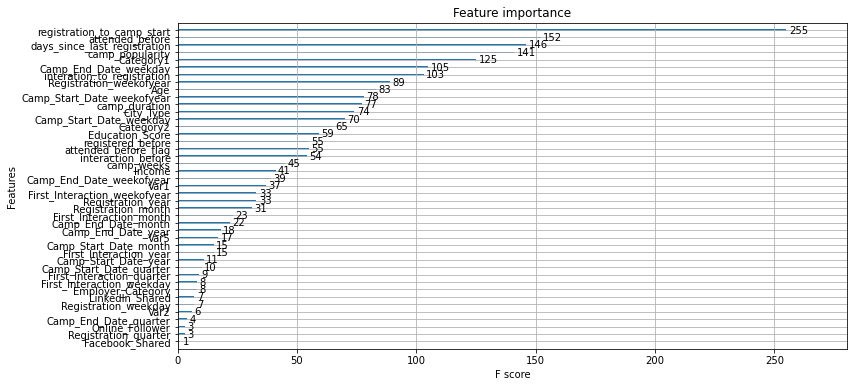

In [62]:
plt.rcParams['figure.figsize'] = (12, 6)
xgb.plot_importance(clf)
plt.show()

# blend

In [63]:
predictions = []
best_seed = params['random_state']
SEEDS = [1,3,10,15,20,33,333,1997,2020,2021, best_seed]
del params['random_state']
for idx, seed_val in enumerate(SEEDS):
    clf = xgb.XGBClassifier(**params, missing=missing_impute, random_state=seed_val)
    clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='auc', verbose=True)
    eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
    eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))
    print('ITERATION: {}, SEED: {}, AUC: {}, ACC: {}'.format(idx + 1, seed_val, eval_score_auc, eval_score_acc))
    predictions.append(clf.predict_proba(df_test[feature_cols])[:, 1])

preds = np.mean(predictions, axis=0).reshape(-1)

ITERATION: 1, SEED: 1, AUC: 0.7531462424762566, ACC: 0.827599032917984
ITERATION: 2, SEED: 3, AUC: 0.754217529511367, ACC: 0.8277850102287521
ITERATION: 3, SEED: 10, AUC: 0.7534323043893612, ACC: 0.8275724647307314
ITERATION: 4, SEED: 15, AUC: 0.7523944294668319, ACC: 0.82714737373469
ITERATION: 5, SEED: 20, AUC: 0.7531127591964716, ACC: 0.8275724647307314
ITERATION: 6, SEED: 33, AUC: 0.7524796450766292, ACC: 0.8271606578283164
ITERATION: 7, SEED: 333, AUC: 0.7531340408591697, ACC: 0.8274927601689737
ITERATION: 8, SEED: 1997, AUC: 0.7534597580278065, ACC: 0.8278115784160047
ITERATION: 9, SEED: 2020, AUC: 0.7540257632536711, ACC: 0.8276388851988629
ITERATION: 10, SEED: 2021, AUC: 0.7543149467382512, ACC: 0.8279045670713887
ITERATION: 11, SEED: 87, AUC: 0.7534414911857782, ACC: 0.8277850102287521


In [64]:
submission = pd.DataFrame({'Patient_ID':df_test['Patient_ID'], 'Health_Camp_ID':df_test['Health_Camp_ID'], 'Outcome':preds})

In [65]:
submission.to_csv('xgb_blended.csv', index=None)

# underfit blend

In [66]:
predictions = []
SEEDS = [1,3,10,15,20,33,333,1997,2020,2021, best_seed]
params['n_estimators'] = int(best_iter - 0.15*best_iter)
for idx, seed_val in enumerate(SEEDS):
    clf = xgb.XGBClassifier(**params, missing=missing_impute, random_state=seed_val)
    clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='auc', verbose=True)
    eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
    eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))
    print('ITERATION: {}, SEED: {}, AUC: {}, ACC: {}'.format(idx + 1, seed_val, eval_score_auc, eval_score_acc))
    predictions.append(clf.predict_proba(df_test[feature_cols])[:, 1])

preds = np.mean(predictions, axis=0).reshape(-1)

ITERATION: 1, SEED: 1, AUC: 0.7506778622783944, ACC: 0.8265761577087596
ITERATION: 2, SEED: 3, AUC: 0.7523243947111894, ACC: 0.8270012487048009
ITERATION: 3, SEED: 10, AUC: 0.750963888607897, ACC: 0.826416748585244
ITERATION: 4, SEED: 15, AUC: 0.7505926110849951, ACC: 0.8264300326788703
ITERATION: 5, SEED: 20, AUC: 0.750528677137896, ACC: 0.8263370440234863
ITERATION: 6, SEED: 33, AUC: 0.7500234664958539, ACC: 0.8262440553681022
ITERATION: 7, SEED: 333, AUC: 0.7512439208796619, ACC: 0.8266027258960121
ITERATION: 8, SEED: 1997, AUC: 0.7505196682594882, ACC: 0.8267887032067802
ITERATION: 9, SEED: 2020, AUC: 0.7525131105646136, ACC: 0.8271208055474375
ITERATION: 10, SEED: 2021, AUC: 0.7519440193508751, ACC: 0.8271340896410638
ITERATION: 11, SEED: 87, AUC: 0.7505744332019715, ACC: 0.826735566832275


In [67]:
submission = pd.DataFrame({'Patient_ID':df_test['Patient_ID'], 'Health_Camp_ID':df_test['Health_Camp_ID'], 'Outcome':preds})
submission.to_csv('xgb_underfits_blended.csv', index=None)

# overfit blend

In [68]:
predictions = []
SEEDS = [1,3,10,15,20,33,333,1997,2020,2021, best_seed]
params['n_estimators'] = int(best_iter + 0.15*best_iter)
for idx, seed_val in enumerate(SEEDS):
    clf = xgb.XGBClassifier(**params, missing=missing_impute, random_state=seed_val)
    clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='auc', verbose=True)
    eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
    eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))
    print('ITERATION: {}, SEED: {}, AUC: {}, ACC: {}'.format(idx + 1, seed_val, eval_score_auc, eval_score_acc))
    predictions.append(clf.predict_proba(df_test[feature_cols])[:, 1])

preds = np.mean(predictions, axis=0).reshape(-1)

ITERATION: 1, SEED: 1, AUC: 0.7551398449075902, ACC: 0.8285289194718244
ITERATION: 2, SEED: 3, AUC: 0.7555445523348743, ACC: 0.8283429421610563
ITERATION: 3, SEED: 10, AUC: 0.7555780534064602, ACC: 0.8284359308164404
ITERATION: 4, SEED: 15, AUC: 0.7548810942985236, ACC: 0.8282632375992987
ITERATION: 5, SEED: 20, AUC: 0.7549115449658376, ACC: 0.8283296580674301
ITERATION: 6, SEED: 33, AUC: 0.7553163769357283, ACC: 0.8286086240335822
ITERATION: 7, SEED: 333, AUC: 0.75478670968411, ACC: 0.8281038284757831
ITERATION: 8, SEED: 1997, AUC: 0.7552525497394348, ACC: 0.8289141581869869
ITERATION: 9, SEED: 2020, AUC: 0.7562811489065423, ACC: 0.8287946013443502
ITERATION: 10, SEED: 2021, AUC: 0.7555659229565772, ACC: 0.8285953399399559
ITERATION: 11, SEED: 87, AUC: 0.7550759109604909, ACC: 0.8284359308164404


In [69]:
submission = pd.DataFrame({'Patient_ID':df_test['Patient_ID'], 'Health_Camp_ID':df_test['Health_Camp_ID'], 'Outcome':preds})
submission.to_csv('xgb_overfits_blended.csv', index=None)

In [71]:
predictions = []
SEEDS = [1,3,10,15,20,33,333,1997,2020,2021, best_seed]
params['n_estimators'] = int(best_iter + 0.25*best_iter)
for idx, seed_val in enumerate(SEEDS):
    clf = xgb.XGBClassifier(**params, missing=missing_impute, random_state=seed_val)
    clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='auc', verbose=True)
    eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
    eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))
    print('ITERATION: {}, SEED: {}, AUC: {}, ACC: {}'.format(idx + 1, seed_val, eval_score_auc, eval_score_acc))
    predictions.append(clf.predict_proba(df_test[feature_cols])[:, 1])

preds = np.mean(predictions, axis=0).reshape(-1)

ITERATION: 1, SEED: 1, AUC: 0.7561624856005617, ACC: 0.8288875899997343
ITERATION: 2, SEED: 3, AUC: 0.7570633414160772, ACC: 0.8290469991232499
ITERATION: 3, SEED: 10, AUC: 0.756685945292831, ACC: 0.8289407263742394
ITERATION: 4, SEED: 15, AUC: 0.7563755335209558, ACC: 0.8289540104678658
ITERATION: 5, SEED: 20, AUC: 0.7560498163523189, ACC: 0.8286351922208348
ITERATION: 6, SEED: 33, AUC: 0.7562842348944159, ACC: 0.8289540104678658
ITERATION: 7, SEED: 333, AUC: 0.7560741662110897, ACC: 0.828648476314461
ITERATION: 8, SEED: 1997, AUC: 0.7564090879679445, ACC: 0.8292462605276442
ITERATION: 9, SEED: 2020, AUC: 0.7569416277058251, ACC: 0.8291134195913813
ITERATION: 10, SEED: 2021, AUC: 0.7562080993302298, ACC: 0.8287547490634714
ITERATION: 11, SEED: 87, AUC: 0.7560590743159398, ACC: 0.8291134195913813


In [72]:
submission = pd.DataFrame({'Patient_ID':df_test['Patient_ID'], 'Health_Camp_ID':df_test['Health_Camp_ID'], 'Outcome':preds})
submission.to_csv('xgb_overfits2_blended.csv', index=None)